In [85]:
import requests
import datetime as dt
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

In [95]:
# using cryptocompare
CC_BASEURL = "https://min-api.cryptocompare.com/data/"
NOMICS_BASEURL = "https://api.nomics.com/v1"

def cc_load_historical_price(fsym, tsym, time_end, freq, nobs, APIKEY):
    if not os.path.exists("../data"):
        os.mkdir("../data")
    
    get_url = CC_BASEURL + "histo" + {"D": "day", "H": "hour", "M": "minute"}[freq]
    
    _params = {
        "fsym": fsym, "tsym": tsym,
        "toTs": int(pd.to_datetime(time_end).timestamp()),
        "limit": nobs,
        "api_key": APIKEY
    }

    file_hash = hash(get_url + str(_params))
    fn = "cryptocompare_{}".format(file_hash)
        
    if os.path.exists("../data/" + fn):
        df = pd.read_csv("../data/" + fn, parse_dates=["time"])
#         df = df.set_index("time")
    else:
        the_request = requests.get(get_url, params=_params)
        df = pd.DataFrame(json.loads(the_request.text)["Data"])
        df["time"] = pd.to_datetime(df["time"], unit="s")

        # Save file
        df.to_csv("../data/" + fn)
#         df = df.set_index("time")
    return df

def nm_load_historical_daily_price(APIKEY, currency, start_time, end_time):
    
    get_url = NOMICS_BASEURL + "/candles"
        
    _params = {
        "key": APIKEY,
        "interval": "1d",
        "currency": currency,
        "start": start_time,
        "end": end_time,
    }

    response = requests.get(get_url, params=_params)
    response_json = response.json()
    df = pd.DataFrame(response_json)
    return df

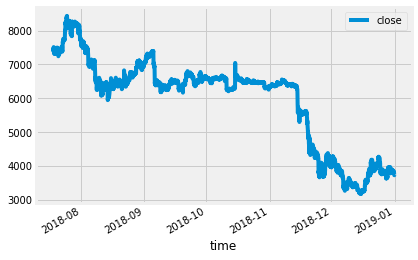

In [130]:
cc_apikey = json.loads(open("../apikeys.json").read())["CRYPTOCOMPARE_APIKEY"]
cc_df = cc_load_historical_price("BTC", "USD", "1/1/2019", "H", 2000, cc_apikey)
earliest = cc_df['time'].min()
cc_df_2 = cc_load_historical_price("BTC", "USD", earliest, "H", 2000, cc_apikey)
# cc_df_2.plot(x="time",y="close")

test = cc_df_2.append(cc_df)
test = test.drop_duplicates().reset_index()
test.plot(x="time",y="close")

2018-10-09 16:00:00
2018-07-18 08:00:00
2018-04-26 00:00:00
2018-02-01 16:00:00
2017-11-10 08:00:00
2017-08-19 00:00:00
2017-05-27 16:00:00
2017-03-05 08:00:00
2016-12-12 00:00:00
2016-09-19 16:00:00
2016-06-28 08:00:00
2016-04-06 00:00:00
2016-01-13 16:00:00
2015-10-22 08:00:00
2015-07-31 00:00:00
2015-05-08 16:00:00
2015-02-14 08:00:00
2014-11-23 00:00:00
2014-08-31 16:00:00
2014-06-09 08:00:00
2014-03-18 00:00:00
2013-12-24 16:00:00
22


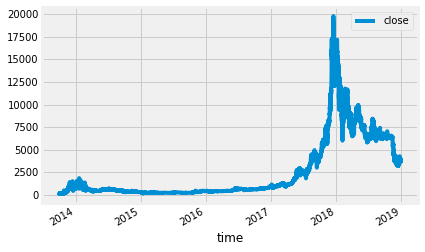

In [138]:
# get hourly data for BTCUSD from 1/1/2014 to 1/1/2019
start_hourly = dt.datetime(2014,1,1)
this_period_end = dt.datetime(2019, 1, 1)

cc_full_data = cc_load_historical_price("BTC", "USD", this_period_end, "H", 2000, cc_apikey)
earliest = cc_full_data['time'].min()

count = 0;
while earliest > start_hourly:
    earliest = cc_full_data['time'].min()
    print(earliest)
    cc_df = cc_load_historical_price("BTC", "USD", earliest, "H", 2000, cc_apikey)
    cc_full_data = cc_df.append(cc_full_data, sort=True)
    cc_full_data = cc_full_data.drop_duplicates().reset_index(drop = True)
    count += 1

print(count)
cc_full_data.plot(x="time", y="close")
cc_full_data.to_csv('20190101_cryptocompare_BTCUSD_hourly.csv')

       close       high        low       open  timestamp    volume
0  754.26817  759.11040  730.24000  730.71622 2014-01-01   6648776
1  783.75158  817.56149  741.49446  751.64903 2014-01-02  11834278
2  807.25303  819.90000  766.23129  783.22811 2014-01-03  12768402
3  829.11378  840.00000  783.02000  808.64012 2014-01-04   9661870
4  905.49452  980.00000  811.22352  829.98589 2014-01-05  20758259


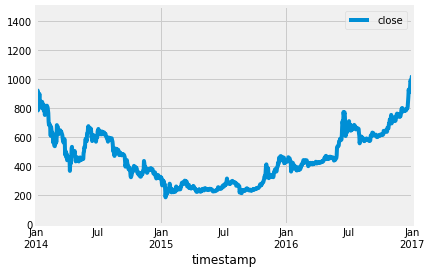

In [184]:
# get daily data from nomics for BTCUSD from 1/1/2014 to 1/1/2019
nm_apikey = json.loads(open("../apikeys.json").read())["NOMICS_APIKEY"]

fmt_dt = lambda d: "{:%Y-%m-%dT%H:%M:%SZ}".format(d)
start_dt = dt.datetime(2014, 1, 1)
end_dt = dt.datetime(2019, 1, 1)
nm_df = nm_load_historical_daily_price(nm_apikey, "BTC", fmt_dt(start_dt), fmt_dt(end_dt))

def cast_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')
    return df

def cast_columns_to_datetime(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_datetime, errors='coerce')
    return df

casted = cast_columns_to_numeric(nm_df, ['close', 'high', 'low', 'open', 'volume'])
casted = cast_columns_to_datetime(casted, ['timestamp'])

print(casted.head())

inspect_start = dt.datetime(2014,1,1)
inspect_end = dt.datetime(2017,1,1)
casted.plot(x="timestamp", y="close", xlim=[inspect_start, inspect_end], ylim=[0,1500])

In [198]:
# the BTCUSD price has 4 regimes - before 1/1/2017, the run-up of 1/1/2017-12/18/2017, 
# the following crash of 12/18/2017 to (say) 4/1/2018, and 4/1/2018 to 1/1/2019. 
preboom_start = dt.datetime(2014, 6, 1)
preboom_end = dt.datetime(2017, 1, 1)

boom_start = dt.datetime(2017, 1, 1)
boom_end = dt.datetime(2017, 12, 18)

bust_start = dt.datetime(2017, 12, 18)
bust_end = dt.datetime(2018, 4, 1)

curr_start = dt.datetime(2018, 4, 1)
curr_end = dt.datetime(2019, 1, 1)

regimes = {}
regimes["preboom"] = [preboom_start, preboom_end]
regimes["boom"] = [boom_start, boom_end]
regimes["bust"] = [bust_start, bust_end]
regimes["current"] = [curr_start, curr_end]

pctls = [90, 99, 99.9, 99.99, 99.999]
hours = [1, 2, 6, 12, 24]
hours_labels = list(map(lambda x: str(x) + "h", hours))

# for each of these regimes, find the absolute value in the size of the 1-day move 
cc_hourly = pd.read_csv("20190101_cryptocompare_BTCUSD_hourly.csv")
cc_hourly = cast_columns_to_datetime(cc_hourly, ['time'])

stored_margins = {}
stored_raw = {}

In [199]:
for regime_name,regime_dates in regimes.items():
    regime_start = regime_dates[0]
    regime_end = regime_dates[1]
    this_regime = cc_hourly.loc[cc_hourly['time'].between(regime_start, regime_end, inclusive = True)]

    # get percent changes for each increment of hours
    for index,hour in enumerate(hours, start = 0):
        this_regime.loc[:,hours_labels[index]] = this_regime['close'].pct_change(hour)
    
    # create table with margin numbers
    margins = pd.DataFrame(index = pctls, columns = hours_labels)
    
    for pctl in pctls:
        for hours_label in hours_labels:
            margins.loc[pctl,hours_label] = np.nanpercentile(this_regime[hours_label].abs(), pctl)

    stored_margins[regime_name] = margins
    stored_raw[regime_name] = this_regime
#     print(regime_name)
#     print(margins)

preboom
                1h         2h         6h        12h        24h
90.000  0.00822565   0.011546  0.0205321  0.0305412  0.0457252
99.000   0.0263056  0.0377052  0.0614495  0.0823554   0.117874
99.900   0.0608866  0.0787571   0.113711   0.153939   0.215516
99.990     0.17878   0.193981   0.188503   0.258575   0.267134
99.999    0.336515   0.338598   0.333652   0.329613   0.312615
boom
               1h         2h         6h        12h        24h
90.000   0.015172  0.0214334  0.0369726  0.0530352  0.0785272
99.000  0.0360998  0.0529541  0.0857643    0.11319   0.162962
99.900  0.0713212  0.0940991   0.129676   0.173237   0.233737
99.990    0.11682   0.129994   0.196228   0.242856   0.258089
99.999   0.132535   0.144823   0.217077    0.24574    0.26986
bust
               1h         2h         6h        12h       24h
90.000  0.0248575  0.0347458  0.0578529  0.0803863   0.11535
99.000  0.0534705  0.0725156    0.10505   0.139929  0.203365
99.900  0.0843494   0.111454   0.174283   0.20912

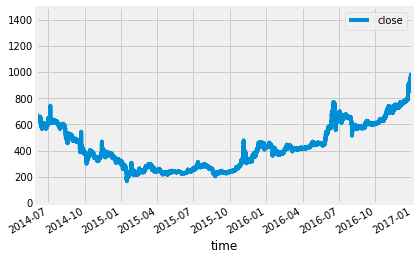

In [201]:
# inspect a time period
to_inspect = stored_raw["preboom"]

inspect_start = dt.datetime(2014,6,1)
inspect_end = dt.datetime(2017,1,1)
to_inspect.plot(x="time", y="close", xlim=[inspect_start, inspect_end], ylim=[0,1500])

In [203]:
# concatenate dataframes
all_regime_labels = list(stored_margins.keys())
all_regime_dfs = list(stored_margins.values())
for_csv = pd.concat(all_regime_dfs, keys=all_regime_labels)
# write these dataframes to csv
for_csv.to_csv('20190101_btcusd_margins.csv')    